# Data import

In [26]:
import pandas as pd
import numpy as np

In [27]:
# Read training data from CSV
train_data_raw = pd.read_csv('resources/tdata.csv')
train_data_raw.shape

(65436, 4)

In [28]:
# Read validation data from CSV
validate_data_raw = pd.read_csv('resources/tdata.csv')
validate_data_raw.shape

(65436, 4)

In [29]:
# Choose only columns containing features we want to use for training
feature_list = ["value"]
features = len(feature_list)
train_data_selected = train_data_raw[feature_list].as_matrix().astype(np.float32)
validate_data_selected = validate_data_raw[feature_list].as_matrix().astype(np.float32)

# Data visualization

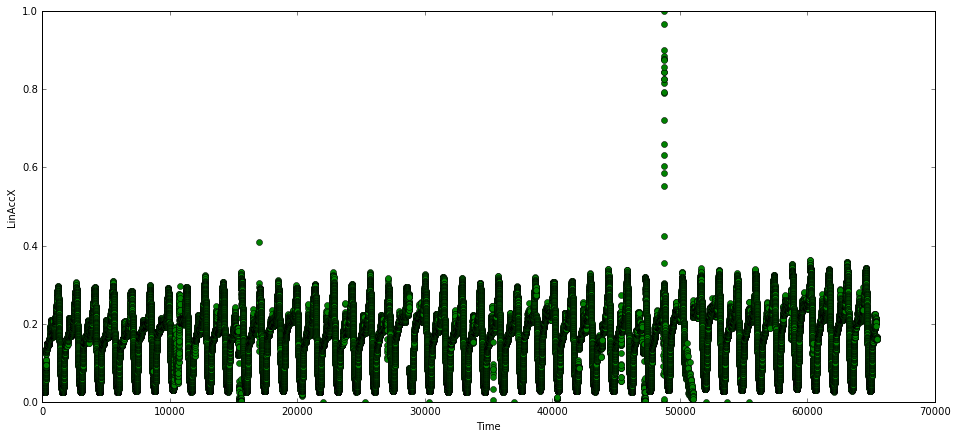

In [30]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(16, 7)

plt.plot(range(len(train_data_raw)), train_data_raw[feature_list], "go")
plt.ylabel('LinAccX')
plt.xlabel('Time')
plt.show()

In [76]:
# Plot the training vs test mse
def plot_errors(train_mse, test_mse):
    epochs = range(len(train_mse))
    figsize(16, 7)
    plt.plot(epochs, train_mse, label='Train')
    plt.plot(epochs, test_mse, label='Test')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Multi layer perceptron

## Data preparation

In [77]:
# Convert a dataset into a windowed format - append *window - 1* records to the back of each record. 
# For example:
# window = 2
# dataset =
# [
#  [1, 2, 3],
#  [2, 3, 4],
#  [5, 6, 7]
# ]
#
# Will result in:
# [
#  [0, 0, 0, 1, 2, 3], # padding with 0 since there were no observations before the first one
#  [1, 2, 3, 2, 3, 4],
#  [2, 3, 4, 5, 6, 7]
# ]
def prepare_dataset(dataset, window):
    windowed_data = []
    for i in range(len(dataset)):
        start = i + 1 - window if i + 1 - window >= 0 else 0
        observation = dataset[start : i + 1,]
        to_pad = (window - i - 1 if i + 1 - window < 0 else 0) * features
        observation = observation.flatten()
        observation = np.lib.pad(observation, (to_pad, 0), 'constant', constant_values=(0, 0))
        windowed_data.append(observation)
    return np.array(windowed_data)
    
# Window size - the bigger this value is, the longer our network will "retain" past information i.e. it will take longer
# for newer state to become significant but it will also mean we will use the time dependency factor more into account.
window = 25

# Convert our data into windowed formats
data_train = prepare_dataset(train_data_selected, window)
data_validate = prepare_dataset(validate_data_selected, window)

In [78]:
from __future__ import print_function
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

In [79]:
# Split the data into training and testing sets
# When working with time-series data you usually should not do random samplic as temoporal dependency between observations
# is of great important. The simples way to do a split in such a situation is just find a split point in the data
# and use everything left to that point as training and the rest as test data.
rows = len(data_train)
split_factor = 0.8
train = data_train[0:int(rows*split_factor)]
test = data_train[int(rows*split_factor):]

In [80]:
# Create an iterator, which will feed our data in a batched fashion into MXNet
batch_size = 256
train_data = mx.gluon.data.DataLoader(train, batch_size, last_batch='keep', shuffle=False)
test_data = mx.gluon.data.DataLoader(test, batch_size, last_batch='keep', shuffle=False)

## Network modelling

In [81]:
ctx = mx.cpu() # use mx.cpu() on machines with no GPU

In [82]:
# For this network we will use our windowed data representation, so each record will actually contain all the features
# from *window* number of records hence or total input size:
total_features = window * features

model = gluon.nn.Sequential()
with model.name_scope():
    # Connection between input and first hidden layer
    model.add(gluon.nn.Dense(16, activation='tanh'))
    model.add(gluon.nn.Dropout(0.25))

    model.add(gluon.nn.Dense(8, activation='tanh'))
    model.add(gluon.nn.Dropout(0.25))
    
    model.add(gluon.nn.Dense(16, activation='tanh'))
    model.add(gluon.nn.Dropout(0.25))
    
    # Connection between hidden layer and our output layer - since it is an autoencoder we want the size to be same as input size
    model.add(gluon.nn.Dense(total_features))

# Use the non default Xavier parameter initializer
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

# Use Adam optimizer for training
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

# Similarly to previous example we will use L2 loss for evaluation
L = gluon.loss.L2Loss()

## Training

In [83]:
# Evaluation function
def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = data
        output = model(data)
        loss = L(output, label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return loss_avg

In [84]:
%%time
epochs = 50

all_train_mse = []
all_test_mse = []

# Gluon training loop
for e in range(epochs):
    for i, data in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = data
        with autograd.record():
            output = model(data)
            loss = L(output, label)
            loss.backward()
        trainer.step(data.shape[0])
    
    train_mse = evaluate_accuracy(train_data, model, L)
    test_mse = evaluate_accuracy(test_data, model, L)
    all_train_mse.append(train_mse)
    all_test_mse.append(test_mse)

CPU times: user 1min 8s, sys: 6.64 s, total: 1min 15s
Wall time: 54.9 s


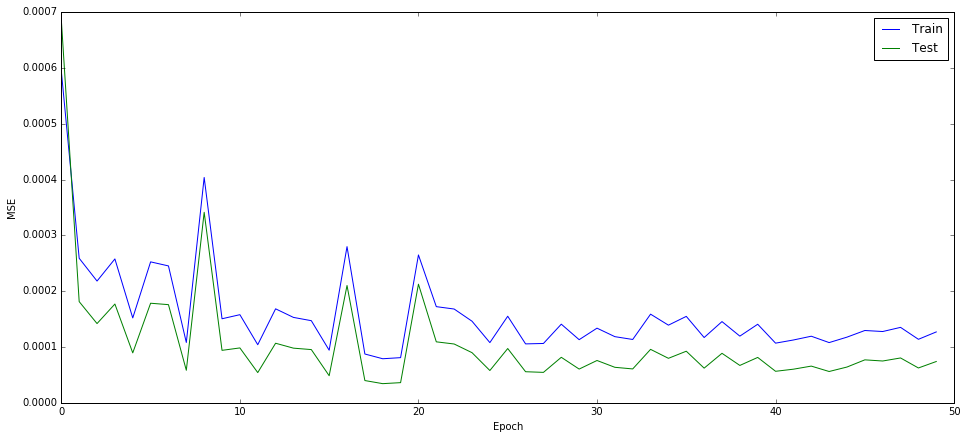

In [40]:
plot_errors(all_train_mse, all_test_mse)

In [85]:
# Helper method running predictions in a batched fashion
def predict(to_predict, L):
    predictions = []
    for i, data in enumerate(to_predict):
        input = data.as_in_context(ctx)
        out = model(input)
        prediction = L(out, input).asnumpy().flatten()
        predictions = np.append(predictions, prediction)
    return predictions

In [86]:
train_data = mx.gluon.data.DataLoader(train, batch_size, shuffle=False)

train_predictions = predict(train_data, L)
threshold =  np.mean(train_predictions) + 3*np.std(train_predictions)

In [87]:
threshold =  np.mean(train_predictions) + 2*np.std(train_predictions)

## Validation data

In [ ]:
validate_data = mx.gluon.data.DataLoader(data_validate, batch_size, shuffle=False)

validation_predictions = predict(validate_data, L)

anomaly = list(map(lambda v: v > threshold, validation_predictions))


In [ ]:
# Result visualization
anomaly = list(map(lambda v: "red" if v else "green", anomaly))
figsize(16, 7)
plt.scatter(list(range(len(validate_data_raw["value"]))), validate_data_raw["value"], c=anomaly)
plt.ylabel('LinAccX')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
f1_score(validate_data_raw['label'], anomaly) 

# Long-short term memory

## Data preparation

In [88]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np

In [89]:
# Setup iterators for Gluon to feed our model with batched data during training
batch_size = 128

# Split the data into train and test
rows = len(train_data_selected)
split_factor = 0.8
train = train_data_selected.astype(np.float32)[0:int(rows*split_factor)]
test = train_data_selected.astype(np.float32)[int(rows*split_factor):]

train_data = mx.gluon.data.DataLoader(train, batch_size, shuffle=False)
test_data = mx.gluon.data.DataLoader(test, batch_size, shuffle=False)

## Network modelling

In [90]:
ctx = mx.cpu() # use mx.cpu() on machines with no GPU

In [94]:
window = 1

model = mx.gluon.nn.Sequential()
with model.name_scope():
    model.add(mx.gluon.rnn.LSTM(window, dropout=0.35))
    model.add(mx.gluon.rnn.LSTM(features))
    # model.add(mx.gluon.rnn.LSTM(features, dropout=0.35))

# Use the non default Xavier parameter initializer
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

# Use Adam optimizer for training
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.01})

# Similarly to previous example we will use L2 loss for evaluation
L = gluon.loss.L2Loss()

## Training

In [95]:
# Evaluation function
def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, window, features))
        label = data
        output = model(data)
        loss = L(output, label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return loss_avg

In [96]:
%%time
epochs = 10

all_train_mse = []
all_test_mse = []

# Gluon training loop
for e in range(epochs):
    for i, data in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1, window, features))
        label = data
        with autograd.record():
            output = model(data)
            loss = L(output, label)
        loss.backward()
        trainer.step(batch_size)
    
    train_mse = evaluate_accuracy(train_data, model, L)
    test_mse = evaluate_accuracy(test_data, model, L)
    all_train_mse.append(train_mse)
    all_test_mse.append(test_mse)
    print(e)

0
1
2
3
4
5
6
7
8
9
CPU times: user 52min 51s, sys: 7min 40s, total: 1h 32s
Wall time: 1h 22s


In [ ]:
plot_errors(all_train_mse, all_test_mse)

In [ ]:
# Helper method running predictions in a batched fashion
def predict(to_predict, L):
    predictions = []
    for i, data in enumerate(to_predict):
        input = data.as_in_context(ctx).reshape((-1,features,1))
        out = model(input)
        prediction = L(out, input).asnumpy().flatten()
        predictions = np.append(predictions, prediction)
    return predictions

In [ ]:
train_data = mx.gluon.data.DataLoader(train_data_selected.astype(np.float32), batch_size, shuffle=False)

train_predictions = predict(train_data, L)
threshold =  np.mean(train_predictions) + 3*np.std(train_predictions)

## Validation

In [ ]:
validate_data = mx.gluon.data.DataLoader(validate_data_selected.astype(np.float32), batch_size, shuffle=False)

validation_predictions = predict(validate_data, L)

In [ ]:
anomaly = list(map(lambda v: v > threshold, validation_predictions))

In [ ]:
# Result visualization
anomaly = list(map(lambda v: "red" if v else "green", anomaly))
figsize(16, 7)
plt.scatter(list(range(len(validate_data_raw["value"]))), validate_data_raw["value"], c=anomaly)
plt.ylabel('LinAccX')
plt.show()

In [71]:
from sklearn.metrics import f1_score
f1_score(validate_data_raw['label'], anomaly) 

0.014701182486417387